# Homework_2023_05_25 pytorch进阶
教师：胡俊峰

助教：陈福康 谷东润

本次作业总分为12分，其中2分为附加分。

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchinfo import summary #pip install torchinfo

## 第零部分 pytorch进阶知识

### 0.1 神经网络模型可视化

In [2]:
#这里定义一个简单神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model0 = Net()
print("model layer settings:\n",model0)

#可以用该summary方法接收给定的input_size，用来确定每一层网络的output_size，从而对神经网络的设计进行debug
print("\nmodel layer output/param sizes:")
summary(model0,input_size=(1,28,28),device='cpu')

model layer settings:
 Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

model layer output/param sizes:


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Linear: 1-3                            [1, 50]                   16,050
├─Linear: 1-4                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

### 0.2 pytorch计算图

Pytorch的计算图由节点和边组成，节点表示张量或者Function，边表示张量和Function之间的依赖关系。计算图的正向传播是立即执行的。无需等待完整的计算图创建完毕，每条语句都会在计算图中动态添加节点和边，并立即执行正向传播得到计算结果。如果在程序中使用了backward方法执行了反向传播，或者利用torch.autograd.grad方法计算了梯度，那么创建的计算图会被立即销毁，释放存储空间。

可以在backward时设置retain_graph为True来保留计算图

In [5]:
x = torch.tensor(2.0,requires_grad = True)  #表明x是叶子节点，需要保留梯度
y = x**2 + 2 * x + 1
y.backward() #首次调用backwards，反向传播后计算图即被销毁
print(x.grad) #2·x+2 = 6
#再次调用会报错
# y.backward()

tensor(6.)


In [6]:
x = torch.tensor(2.0,requires_grad = True)  #表明x是叶子节点，需要保留梯度
y = x**2 + 2 * x + 1
y.backward(retain_graph=True)  #本次反向传播的计算图不被销毁
print(x.grad) #2·x+2 = 6

y.backward(retain_graph=True)
print(x.grad) #梯度累加

x.grad.zero_()#梯度清零
y.backward() #未设置retain_graph，本次反向传播的计算图被销毁
print(x.grad) #2·x+2 = 6

tensor(6.)
tensor(12.)
tensor(6.)


在下面代码中，loss.backward()语句调用后，依次发生以下计算过程：

1，loss自己的grad梯度赋值为1，即对自身的梯度为1。<br>
2，loss根据其自身梯度以及关联的backward方法，计算出其对应的自变量即y1和y2的梯度，将该值赋值到y1.grad和y2.grad。<br>
3，y1和y2根据其自身梯度以及关联的backward方法, 计算出其对应的自变量x的梯度，x.grad将其收到的来自y1和y2的多个梯度值累加。

上述步骤的求梯度顺序和对多个梯度值的累加规则恰好是求导链式法则的程序表述。

In [20]:
x = torch.tensor(3.0,requires_grad=True)
y1 = 2 * x + 1
y2 = x - 1
loss = (y1 - y2)**2
loss.backward()
x.grad #2*（y1 - y2) *(2 - 1)

tensor(10.)

如果打印loss.grad,我们会发现该值并不是我们期望的1,而是 None，类似地 y1.grad 以及 y2.grad也是 None.这是由于它们不是叶子节点张量。在反向传播过程中，只有 is_leaf=True 的叶子节点，需要求导的张量的导数结果才会被最后保留下来。
叶子节点张量需要满足两个条件：

1，叶子节点张量是由用户直接创建的张量，而非由某个Function通过计算得到的张量。<br>
2，叶子节点张量的 requires_grad属性必须为True.

所有依赖于叶子节点张量的张量, 其requires_grad 属性必定是True的，但其梯度值只在计算过程中被用到，不会最终存储到grad属性中。<br>
如果需要保留中间计算结果的梯度到grad属性中，可以使用 retain_grad方法。<br>
如果仅仅是为了调试代码查看梯度值，可以利用register_hook打印日志。

In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

x = torch.tensor(3.0,requires_grad=True)
y1 = 2 * x + 1
y2 = x - 1
loss = (y1-y2)**2

loss.backward()
print("loss.grad:", loss.grad)
print("y1.grad:", y1.grad)
print("y2.grad:", y2.grad)
print("x.grad:", x.grad)
print(x.is_leaf)
print(y1.is_leaf)
print(y2.is_leaf)
print(loss.is_leaf)

loss.grad: None
y1.grad: None
y2.grad: None
x.grad: tensor(10.)
True
False
False
False


In [25]:
#正向传播
x = torch.tensor(3.0,requires_grad=True)
y1 = 2 * x + 1
y2 = x - 1
loss = (y1-y2)**2

#非叶子节点梯度显示控制
y1.register_hook(lambda grad: print('y1 grad:', grad))
y2.register_hook(lambda grad: print('y2 grad:', grad))
loss.retain_grad()

#反向传播
loss.backward()
print("loss.grad:", loss.grad)
print("x.grad:", x.grad)

y2 grad: tensor(-10.)
y1 grad: tensor(10.)
loss.grad: tensor(1.)
x.grad: tensor(10.)


## 第一部分 pytorch应用

### 1.自定义数据集类（5分）
ImageFolder是torchvision.datasets中实现的用于从文件夹中读取图片数据的通用数据加载器，它继承了torch.utils.data.Dataset,被读取的数据集中的数据文件在磁盘中以如下方式组织，即其默认你的数据集已经自觉按照要分配的类型分成了不同的文件夹，一种类型的文件夹下面只存放一种类型的图片。它以PIL Image格式读取图片，然后使用参数transform对应的函数对图片进行处理,并自动为每个类型文件夹下的图片分配整型数字标签，用来代表其所属的类别，该值默认按照类别名称字典序，从0开始递增。

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```
这里我们实现简化版的自定义MyImageFolder类，用来加载符合上述文件组织形式的数据集，它应该具有以下参数：

`root`：数据集的根目录，满足上述组织形式<br>
`transfrom`：`[callable]`，用来对图片数据进行一些预处理，如裁剪、旋转等，调用方式为`transform(img)`，该值默认为None.

该类具有以下属性（需在`__init__(self,root,transform)`中实现）：

`classes (list)`：类别字符串标签，如`['cat','dog']`，按照字典序排列；<br>
`class_to_idx (dict)`：保存每个类别对应的数字标签，如`{'Cat': 0, 'Dog': 1}`；<br>
`imgs (list)`：其元素形如`(img_path,img_label)`的列表，如`[('root/cat/xxx.png',0),('root/cat/xxy.png',0),('root/dog/xxz.png',1),('root/dog/xyx.png',1)]`.<br>

除此之外，你需要实现：

`__getitem__(self,index:int)`：该函数返回`(data[index],label[index])`,注意这里的`data[index]`是使用`transform`处理后的图片对象，而不是简单的返回`self.imgs[index]`，`label[index]`为其对应的数字标签。<br>
`__len__(self)`：该函数简单的返回数据样本数。

我们已经提供了`default_loader()`函数用于加载指定路径的图片对象。

你可以通过使用`ImageFolder()`类来对比实现效果.


In [26]:
from PIL import Image
import os
def default_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

def path_transform(imgs_path_tuple): #用来将所有的windows反斜杠转化为斜杠
    return [(path.replace('\\','/'),label) for path,label in imgs_path_tuple]

In [32]:
class MyImageFolder(Dataset):
    def __init__(self,root:str,transform = None):   
        super().__init__()
        self.root = root
        self.transform = transform
        self.classes = [i for i in os.listdir(root) if os.path.isdir(os.path.join(root,i))]
        self.class_to_idx = {self.classes[i]:i for i in range(len(self.classes))}
        self.imgs = [(os.path.join(root,cls,img),self.class_to_idx[cls]) for cls in self.classes for img in os.listdir(os.path.join(root,cls))]

    
    def __getitem__(self, index:int):
        image = default_loader(self.imgs[index][0])
        if self.transform:
            image = self.transform(image)
        return image,self.imgs[index][1]
    
    def __len__(self):
        return len(self.imgs)

In [33]:
train_data = MyImageFolder(root = './catsdogs/train/')
test_data = MyImageFolder(root = './catsdogs/test/')

assert path_transform(train_data.imgs) == path_transform(ImageFolder(root = './catsdogs/train/').imgs)#测试self.imgs符合要求
assert np.all(np.array(test_data[0][0]) == np.array(ImageFolder(root = './catsdogs/test/')[0][0])) #测试载入图片对象相同

train_data.classes,test_data.class_to_idx,len(train_data),len(test_data),test_data.imgs[0]

(['Cat', 'Dog'],
 {'Cat': 0, 'Dog': 1},
 1600,
 400,
 ('./catsdogs/test/Cat\\10010.jpg', 0))

### 2.自定义tranform类（2分）
你需要实现一个对图片进行处理的类，该类可以为图片的每个通道添加相同的指定均值、方差和幅值的高斯噪声(正态分布)，具体来说，对于图片的每个通道，有

```img_channel = img_channel + amplitude * gaussian_noise(mean,variance)```，图片的输入格式为(H,W,C)，其中H为高度，W为宽度，C为通道数。

请注意，这里假设img以[0,255]间的整数形式存储，而不是[0,1]间的浮点数。

提示：将Image.Image转化为np.array进行处理，添加加性噪声后，记得clip到[0,255]区间内，并且重新转化为np.uint8类型，最后再还原成Image.Image

In [57]:
from numpy.random import normal as gaussian
class GaussianNoise(object):

    def __init__(self, mean=0.0, variance=1.0, amplitude=1.0):

        self.mean = mean
        self.variance = variance
        self.amplitude = amplitude

    def __call__(self, img:Image.Image) -> Image.Image:
        img = np.array(img)
        img = img + np.expand_dims(self.amplitude * gaussian(self.mean,self.variance,img.shape[0:2]),axis = 2).repeat(3,axis = 2)
        img = np.clip(img,0,255)
        img = Image.fromarray(np.uint8(img))
        
        return img

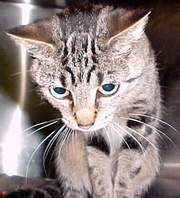

In [35]:
#未添加噪声
train_data = MyImageFolder(root = './catsdogs/train/')
train_data[0][0]

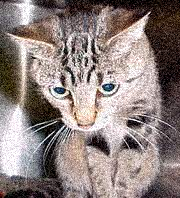

In [62]:
#添加噪声
train_data = MyImageFolder(root = './catsdogs/train/',transform = GaussianNoise(0,20,1))
train_data[0][0]

### 3.神经网络模型训练与调优

#### 1）数据预处理（1分）
我们加载的数据集共有2000张图片，其中包含两个类别：cat和dog，分别用0和1作为类别标签。训练集和测试集的比例为4：1，各自包含均等数目的两种类别的图片。需要注意的是，我们这里使用的数据集中的图片具有不同的宽度和高度，因此你需要设置train_data和test_data的transform参数，使得所有图片统一成64*64的三通道图片，另外还需要把PIL Image转化为tensor格式。（提示：使用torchvision.transforms中的类和torchvision.transforms.Compose()函数，我们已经导入了transforms包）

In [76]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

#加载数据
batch_size = 16
train_data = MyImageFolder(root = './catsdogs/train/',transform = transform)
test_data = MyImageFolder(root = './catsdogs/test/',transform = transform)
train_loader = DataLoader(train_data,batch_size = batch_size,shuffle = True)
test_loader = DataLoader(test_data,batch_size = batch_size)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )

#### 2）训练/测试接口与可视化（供阅读和调试）
下面定义和实现了四个通用函数，train_step()用于每个epoch的训练，test_step()用于测试，两者均返回完整遍历指定数据集后的loss和预测accuracy，train()用于在给定参数下的完整训练，该函数返回训练过程中每个epoch的数据日志，visualize()使用该日志作为参数，在同一张图中绘制训练集和测试集上accuray和loss的曲线，其横轴为epoch数，左侧Y轴为loss，右侧Y轴为accuracy。输出结果样例参考下面第三问。

In [82]:
def train_step(model, dataloader,loss_fn,optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval() 
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, scheduler = None):

    """
        参数scheduler在需要控制学习率随训练过程发生变化时设置，默认为None
    """
    results = {"train_loss": [],"train_acc": [],"test_loss": [],"test_acc": []}
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,dataloader=test_dataloader,loss_fn=loss_fn)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if scheduler is not None:
            scheduler.step(metrics=test_loss)

    return results

def visualize(results:dict):
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    epoches = len(results['train_loss'])
    lg1 = ax1.plot(range(epoches),results['train_loss'],c = 'r',label = 'train_loss')
    lg2 = ax1.plot(range(epoches),results['test_loss'],c = 'b',label = 'test_loss')
    lg3 = ax2.plot(range(epoches),results['train_acc'],'s--',c = 'r',label = 'train_acc')
    lg4 = ax2.plot(range(epoches),results['test_acc'],'s--',c = 'b',label = 'test_acc')
    lg = lg1 + lg2 +lg3 + lg4
    labs = [l.get_label() for l in lg]
    ax1.legend(lg, labs, ncol = 4,bbox_to_anchor=(1.01, 1.1))
    ax1.set_ylabel('loss')
    ax2.set_ylabel('accuracy')
    ax1.set_xlabel('epoches')

#### 3）模型训练与结果可视化（供阅读和调试）
我们使用下面的MyNet()网络在训练集上进行30个epoches的训练，它包含三个卷积层（和随后的池化层）与两个全连接层，使用交叉熵损失函数，初始学习率设置为0.001，在训练完成后，我们使用上面实现的可视化函数对结果进行展示。单次训练需要10min左右（助教的屑笔记本），所以不要随意无限制地扩大网络结构或者增加epoches。

In [102]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*6*6,256),
            nn.ReLU(),
            nn.Linear(256,2),
        )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        # 随机丢弃一些神经元
        x = F.dropout(x, p=0.3, training=self.training)
        return x

Epoch: 1 | train_loss: 0.6944 | train_acc: 0.4806 | test_loss: 0.6923 | test_acc: 0.5225
Epoch: 2 | train_loss: 0.6929 | train_acc: 0.5200 | test_loss: 0.6910 | test_acc: 0.5225
Epoch: 3 | train_loss: 0.6839 | train_acc: 0.5494 | test_loss: 0.6898 | test_acc: 0.5425
Epoch: 4 | train_loss: 0.6612 | train_acc: 0.5956 | test_loss: 0.6714 | test_acc: 0.5925
Epoch: 5 | train_loss: 0.6459 | train_acc: 0.6319 | test_loss: 0.6504 | test_acc: 0.6200
Epoch: 6 | train_loss: 0.6264 | train_acc: 0.6381 | test_loss: 0.6726 | test_acc: 0.6175
Epoch: 7 | train_loss: 0.6009 | train_acc: 0.6856 | test_loss: 0.6410 | test_acc: 0.6225
Epoch: 8 | train_loss: 0.5762 | train_acc: 0.6987 | test_loss: 0.6182 | test_acc: 0.6450
Epoch: 9 | train_loss: 0.5424 | train_acc: 0.7206 | test_loss: 0.6688 | test_acc: 0.6775
Epoch: 10 | train_loss: 0.5066 | train_acc: 0.7631 | test_loss: 0.6532 | test_acc: 0.6925
Epoch: 11 | train_loss: 0.4540 | train_acc: 0.7881 | test_loss: 0.6442 | test_acc: 0.7050
Epoch: 12 | train_l

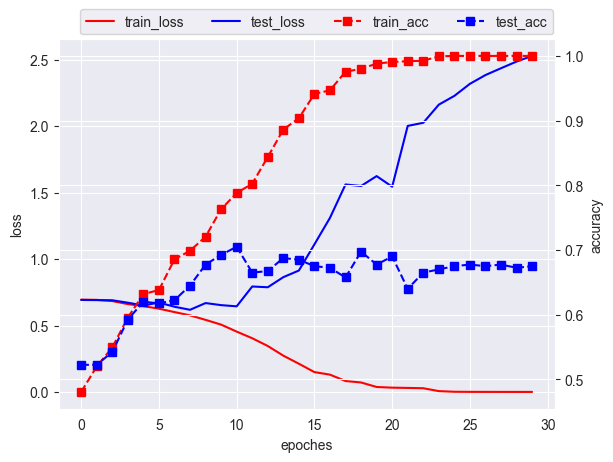

In [78]:
torch.manual_seed(42)
model = MyNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
results = train(model=model, train_dataloader=train_loader,test_dataloader=test_loader,optimizer=optimizer,loss_fn=loss_fn, epochs=30)
print(test_step(model=model,dataloader=train_loader,loss_fn=loss_fn))
print(test_step(model=model,dataloader=test_loader,loss_fn=loss_fn))
visualize(results)

#### 4）优化与改进（4分）
你可能已经注意到，在测试集上的loss随着epoches增大，最后反而在变大，且准确率难以提升，这说明可能出现了过拟合，为了减轻这种现象，提高模型的泛化能力，请你从包括但不限于课件中提到的“可改进的点”中，选取至少两种改进方式。如果需要对神经网络结构进行修改，你可以在3）中的MyNet()中原地修改；其他如学习率的动态调整、数据增强、正则化等，请在下面重新实现。

并在下方markdown单元格中用文字简要介绍你选取的改进方式。（不必过分追求准确率和loss的正向优化，方式合理即可，但不可出现原则上的错误，如对测试集进行随机旋转）

#TODO 你的改进方案：
1. 随机dropout一些神经元来防止过拟合
2. 使用数据增强，对训练集进行随机高斯噪声
3. 使用ReduceLROnPlateau动态调整学习率

In [94]:
#TODO  可能进行的数据增强，如果没有选择进行该操作，该单元格不用执行！
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    GaussianNoise(amplitude=2),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])
#加载数据
batch_size = 16
train_data = MyImageFolder(root = './catsdogs/train/',transform = train_transform)
test_data = MyImageFolder(root = './catsdogs/test/',transform = test_transform)
train_loader = DataLoader(train_data,batch_size = batch_size,shuffle = True)
test_loader = DataLoader(test_data,batch_size = batch_size)

Epoch: 1 | train_loss: 0.6934 | train_acc: 0.4975 | test_loss: 0.6923 | test_acc: 0.5025
Epoch: 2 | train_loss: 0.6913 | train_acc: 0.5400 | test_loss: 0.6886 | test_acc: 0.5675
Epoch: 3 | train_loss: 0.6857 | train_acc: 0.5750 | test_loss: 0.6855 | test_acc: 0.6050
Epoch: 4 | train_loss: 0.6698 | train_acc: 0.5975 | test_loss: 0.6723 | test_acc: 0.6050
Epoch: 5 | train_loss: 0.6516 | train_acc: 0.6162 | test_loss: 0.6467 | test_acc: 0.6450
Epoch: 6 | train_loss: 0.6290 | train_acc: 0.6525 | test_loss: 0.6404 | test_acc: 0.6350
Epoch: 7 | train_loss: 0.6144 | train_acc: 0.6644 | test_loss: 0.6244 | test_acc: 0.6575
Epoch: 8 | train_loss: 0.6083 | train_acc: 0.6631 | test_loss: 0.6250 | test_acc: 0.6600
Epoch: 9 | train_loss: 0.5808 | train_acc: 0.7050 | test_loss: 0.6195 | test_acc: 0.6675
Epoch: 10 | train_loss: 0.5647 | train_acc: 0.7100 | test_loss: 0.6080 | test_acc: 0.6625
Epoch: 11 | train_loss: 0.5620 | train_acc: 0.7125 | test_loss: 0.5912 | test_acc: 0.6925
Epoch: 12 | train_l

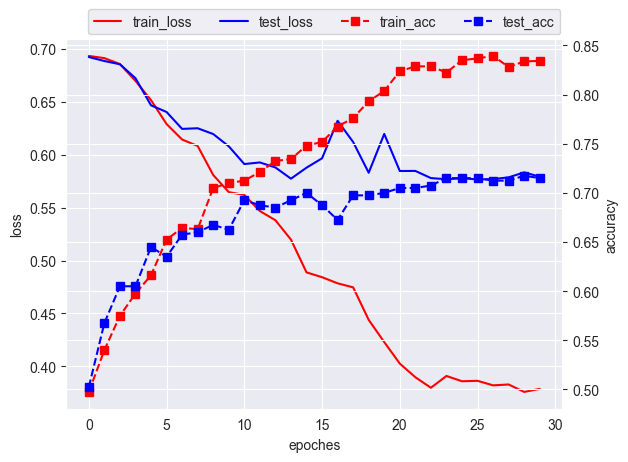

In [103]:
torch.manual_seed(42)
model = MyNet().to(device)
loss_fn = nn.CrossEntropyLoss()

#TODO 可能进行的超参数优化
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
#TODO 可能进行的学习率动态调整
# 防止过拟合
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
results = train(model=model, train_dataloader=train_loader,test_dataloader=test_loader,optimizer=optimizer,loss_fn=loss_fn, epochs=30,scheduler=scheduler)
print(test_step(model=model,dataloader=train_loader,loss_fn=loss_fn))
print(test_step(model=model,dataloader=test_loader,loss_fn=loss_fn))
visualize(results)